### Описание проекта

Проект предоставлен компанией «Цифра». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Задача построить модель для предсказания коэффициента восстановления золота из золотосодержащей руды. Модель поможет оптимизировать добычу золота для промышленного предприятия. Предоставлены данные об добыче и очистке руды.

### Описание данных
#### Технологический процесс
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate **— ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

#### Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи
Наименование признаков
Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]
Пример: rougher.input.feed_ag

### Задача
Нужно спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`.

## Содержание

1. [Подготовка данных](#1.-Подготовка-данных)
2. [Анализ данных](#2.-Анализ-данных)
3. [Модель](#3.-Модель)
4. [Тестирование модели](#4.-Тестирование-модели)
5. [Вывод](#5.-Вывод)

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)}, style='whitegrid')
from IPython.display import display
from IPython.display import Image 
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('gold_recovery_train.csv', index_col='date', parse_dates=True)
df_test = pd.read_csv('gold_recovery_test.csv', index_col='date', parse_dates=True)
df_full = pd.read_csv('gold_recovery_full.csv', index_col='date', parse_dates=True)

df_list = [df_train, df_test, df_full]

display(df_train.head())
display(df_test.head())
display(df_full.head())

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                     

Формула для расчета эффективности обогащения:

$$
Recovery =  \frac{C \times (F - T)}  {F \times (C - T)}
$$
где:
- $C$ — доля золота в концентрате после флотации/очистки;
- $F$ — доля золота в сырье/концентрате до флотации/очистки;
- $T$ — доля золота в отвальных хвостах после флотации/очистки.

In [4]:
#создадим переменные для расчета
y_true = df_train['rougher.output.recovery']
c = df_train['rougher.output.concentrate_au']
f = df_train['rougher.input.feed_au'] 
t = df_train['rougher.output.tail_au']

#расчитаем эффективность по формуле
y_calc = ( (c * (f - t)) / (f * (c - t)) ) * 100

#почистим переменные от пропущенных значений
y_calc = y_calc.dropna()
y_true = y_true[y_calc.index]
y_true = y_true.dropna()
y_calc = y_calc[y_true.index]

print('Размер переменной - фактической и расчетной:', y_true.shape, y_calc.shape)

print('Пропущенные значения в переменной - фактической и расчетной:', y_true.isna().sum(), y_calc.isna().sum())

mae = mean_absolute_error(y_true, y_calc)

print('MAE: {:.3f}%'.format(mae))

Размер переменной - фактической и расчетной: (14287,) (14287,)
Пропущенные значения в переменной - фактической и расчетной: 0 0
MAE: 0.000%


Средня абсолютная ошибка 0%. Следовательно признак `rougher.output.recovery` расчитан правильно. 

Проанализируем признаки, недоступные в тестовой выборке. 

In [5]:
print('Размерность обучеющей и тестовой выборок:', df_train.shape, df_test.shape)

Размерность обучеющей и тестовой выборок: (16860, 86) (5856, 52)


В тестовой выборке 52 признака. Допускаем, что остальные 24 признака в обучающей выборке не потребуются для работы модели.

In [6]:
#посмотрим какие признаки есть в тестовой выборке
df_test.columns

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

Данные признаки потребуются для предсказания модели. По ним и будем обучать модель. Из обучающей выборки уберем лишние.

In [7]:
#посмотрим какие признаки есть в трейне, но нет в тесте
features_notneeded = set(df_train.columns).difference(set(df_test.columns))

#оставим таргеты
features_notneeded = features_notneeded - {'rougher.output.recovery', 'final.output.recovery'} 
features_notneeded

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'secondary_cleane

In [8]:
#удалим лишние признаки
df_train = df_train.drop(features_notneeded, axis=1)

#проверим размер выборки
df_train.shape

(16860, 54)

#### Предобработка тренировочной выборки

In [9]:
#посмотрим пропущенные значения в трейне
df_train.isna().mean().sort_values(ascending=False)

rougher.output.recovery                       0.152610
rougher.input.floatbank11_xanthate            0.112930
final.output.recovery                         0.090214
primary_cleaner.input.sulfate                 0.077521
primary_cleaner.input.depressant              0.074852
rougher.input.floatbank10_sulfate             0.061922
primary_cleaner.input.xanthate                0.058422
rougher.input.floatbank11_sulfate             0.036951
rougher.state.floatbank10_e_air               0.035765
rougher.input.feed_rate                       0.030427
rougher.input.feed_size                       0.024733
secondary_cleaner.state.floatbank2_a_air      0.021530
rougher.input.floatbank10_xanthate            0.020522
rougher.input.feed_sol                        0.017319
rougher.input.feed_pb                         0.013523
secondary_cleaner.state.floatbank2_b_air      0.009193
secondary_cleaner.state.floatbank4_a_air      0.007651
secondary_cleaner.state.floatbank3_a_level    0.006702
secondary_

- 15% пропущенных значений в целевой переменной
- в оcтальных признаках меньше 15% пропусков 

Удалим пропуски. После построения модели посмотрим важность признаков. Если признаки важны, заполним пропуски. И посмотрим как это отразится на качестве модели.


In [10]:
#избавимся от пропусков
df_train_cl = df_train.dropna()

In [11]:
#проверим на дубликаты
df_train_cl.duplicated().sum()

0

In [12]:
#посмотрим общую информацию по трейн выборке
df_train_cl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12679 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   final.output.recovery                       12679 non-null  float64
 1   primary_cleaner.input.sulfate               12679 non-null  float64
 2   primary_cleaner.input.depressant            12679 non-null  float64
 3   primary_cleaner.input.feed_size             12679 non-null  float64
 4   primary_cleaner.input.xanthate              12679 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      12679 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    12679 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      12679 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    12679 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      1267

#### Предобработка тестовой выборки

In [13]:
#посмотрим пропуски в тестовой выборке
df_test.isna().mean().sort_values(ascending=False)

rougher.input.floatbank11_xanthate            0.060280
primary_cleaner.input.sulfate                 0.051571
primary_cleaner.input.depressant              0.048497
rougher.input.floatbank10_sulfate             0.043887
primary_cleaner.input.xanthate                0.028347
rougher.input.floatbank10_xanthate            0.021004
rougher.input.feed_sol                        0.011441
rougher.input.floatbank11_sulfate             0.009392
rougher.input.feed_rate                       0.006831
secondary_cleaner.state.floatbank3_a_air      0.005806
secondary_cleaner.state.floatbank2_b_air      0.003928
rougher.input.feed_size                       0.003757
secondary_cleaner.state.floatbank2_a_air      0.003415
rougher.state.floatbank10_a_air               0.002903
rougher.state.floatbank10_d_air               0.002903
rougher.state.floatbank10_b_air               0.002903
rougher.state.floatbank10_c_air               0.002903
rougher.state.floatbank10_f_air               0.002903
rougher.st

Пропусков не более 6 %. Также удалим пропуски и после построения модели поэсперементируем с заполнение пропусков

In [14]:
#избавимся от пропусков
df_test_cl = df_test.dropna()

In [15]:
#проверим на дубликаты
df_test_cl.duplicated().sum()

0

In [16]:
df_test_cl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5383 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5383 non-null   float64
 1   primary_cleaner.input.depressant            5383 non-null   float64
 2   primary_cleaner.input.feed_size             5383 non-null   float64
 3   primary_cleaner.input.xanthate              5383 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5383 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5383 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5383 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5383 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5383 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5383 

#### Предобработка полного датасета

In [17]:
#посмотрим долю пропусков
df_full.isna().mean().sort_values(ascending=False)

rougher.output.recovery                          0.137304
rougher.output.tail_ag                           0.120488
rougher.output.tail_sol                          0.120444
rougher.output.tail_au                           0.120444
rougher.input.floatbank11_xanthate               0.099357
                                                   ...   
rougher.calculation.sulfate_to_au_concentrate    0.001937
primary_cleaner.state.floatbank8_d_level         0.001893
primary_cleaner.state.floatbank8_b_level         0.001893
primary_cleaner.state.floatbank8_c_level         0.001893
primary_cleaner.input.feed_size                  0.000000
Length: 86, dtype: float64

Также чистим пропуски.

In [18]:
#удалим пропуски
df_full_cl = df_full.dropna()

In [19]:
#проверим на дубликаты
df_full_cl.duplicated().sum()

0

In [20]:
#посмотрим общую информацию 
df_full_cl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16094 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16094 non-null  float64
 1   final.output.concentrate_pb                         16094 non-null  float64
 2   final.output.concentrate_sol                        16094 non-null  float64
 3   final.output.concentrate_au                         16094 non-null  float64
 4   final.output.recovery                               16094 non-null  float64
 5   final.output.tail_ag                                16094 non-null  float64
 6   final.output.tail_pb                                16094 non-null  float64
 7   final.output.tail_sol                               16094 non-null  float64
 8   final.output.tail_au                     

### Вывод

- проверили правильность расчета эффективности обогащения золота, средняя абсолютная ошибка составила 0%;
- удалили пропуски в трех датасетах;
- проверили, что нет дубликатов.

# 2. Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

#### Анализ концентрации золота (Au)

In [21]:
#определим признаки концентрации золота
au_concent_features = [i for i in df_full.columns if 'concentrate_au' in i]
au_concent_features

['final.output.concentrate_au',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_au']

In [22]:
#посмотрим описательные статистики переменных
df_full_cl[au_concent_features].describe()

,final.output.concentrate_au,primary_cleaner.output.concentrate_au,rougher.output.concentrate_au
count,16094.000000,16094.000000,16094.000000
mean,44.307437,32.065559,20.052152
std,4.210135,5.205760,3.620905
min,0.000000,0.000000,0.000000
25%,43.431184,30.299696,19.142941
50%,44.986391,32.643752,20.507430
75%,46.253912,34.828516,21.916971
max,51.571885,45.933934,28.824507


In [23]:
def distplot_concent_me(df, features):
    for feat in features:
        sns.distplot(df[feat], kde=False)
        plt.legend(features)
        plt.title('Распределение концентрации металла на разных этапах очистки')

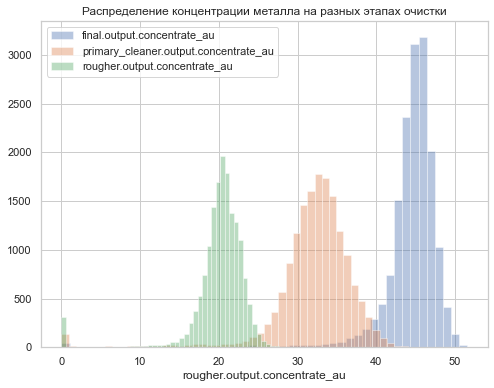

In [24]:
#посмотрим распределение концентрации золота на разниых этапах
for feat in au_concent_features:
    sns.distplot(df_full_cl[feat], kde=False)
    plt.legend(au_concent_features)
    plt.title('Распределение концентрации металла на разных этапах очистки')

- распределения приближенны к нормальным
- ближе к нулю есть выбросов
- с каждым последующим этапом отчистки, увеличивается концентрация золота

#### Анализ концентрации серебра (Ag)

In [25]:
#выделим признаки концентрации серебра
ag_concent_features = [i for i in df_full_cl.columns if 'concentrate_ag' in i]
ag_concent_features

['final.output.concentrate_ag',
 'primary_cleaner.output.concentrate_ag',
 'rougher.output.concentrate_ag']

In [26]:
#посмотрим описательные статистики
df_full_cl[ag_concent_features].describe()

,final.output.concentrate_ag,primary_cleaner.output.concentrate_ag,rougher.output.concentrate_ag
count,16094.000000,16094.000000,16094.000000
mean,5.190976,8.674853,12.084945
std,1.333257,1.944943,2.697948
min,0.000000,0.000000,0.000000
25%,4.277722,7.531083,10.664288
50%,5.083578,8.723466,12.232367
75%,5.894149,9.955605,13.835104
max,16.001945,15.005789,21.725695


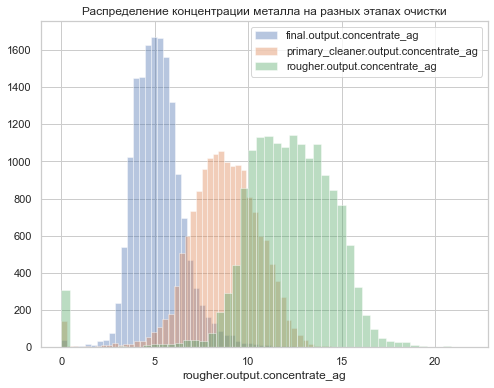

In [27]:
#построим распределение концентрации серебра на разных этапах
distplot_concent_me(df_full_cl, ag_concent_features)

- распределение ближе к нормальному
- ближе к нулю есть выбросы
- с каждым последующим этапом очистки, уменьшается концентрация серебра (обратная ситуация с золотом)

#### Анализ концентрации свинца (Pb)

In [28]:
#выделим признаки концетрации свинца
pb_concent_features = [i for i in df_full_cl.columns if 'concentrate_pb' in i]
pb_concent_features

['final.output.concentrate_pb',
 'primary_cleaner.output.concentrate_pb',
 'rougher.output.concentrate_pb']

In [29]:
#посмотрим описательные статистики
df_full_cl[pb_concent_features].describe()

,final.output.concentrate_pb,primary_cleaner.output.concentrate_pb,rougher.output.concentrate_pb
count,16094.000000,16094.000000,16094.000000
mean,9.997593,9.884018,7.553095
std,1.568785,2.402325,1.688073
min,0.000000,0.000000,0.000000
25%,9.103183,8.822906,6.696978
50%,10.092386,10.182557,7.698308
75%,11.030644,11.399084,8.510786
max,17.031899,17.081278,12.702148


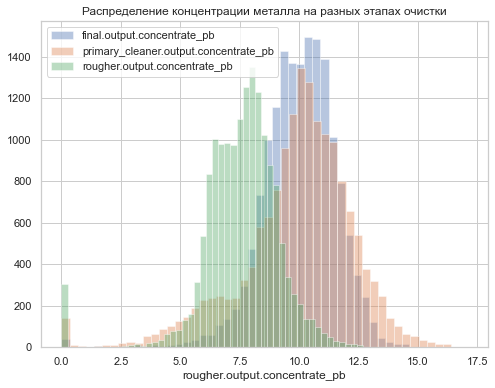

In [30]:
#посмотроим распределение концентрации свинца на разных этапах
distplot_concent_me(df_full_cl, pb_concent_features)

- распределения приближенны к нормальному
- есть выбросы ближе к нулю
- после флотации концетрации свинца немного увеличивается, на последующих этапах практически не изменяется

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

In [31]:
#сохраним название призноков гранул сырья
feed_size_features = [i for i in df_train_cl.columns if 'feed_size' in i]
feed_size_features

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

In [32]:
#посмотрим статистики
display(df_train_cl[feed_size_features].describe().style.set_caption(
    'Описательные статистики признаков гранул сырья в обучающей выборке'))

display(df_test_cl[feed_size_features].describe().style.set_caption(
    'Описательные статистики признаков гранул сырья в тестовой выборке'))

,primary_cleaner.input.feed_size,rougher.input.feed_size
count,12679.000000,12679.000000
mean,7.339055,58.414412
std,0.600689,20.441275
min,1.080000,9.659576
25%,6.980000,48.721041
50%,7.300000,54.651129
75%,7.700000,63.719220
max,10.470000,484.967466


,primary_cleaner.input.feed_size,rougher.input.feed_size
count,5383.000000,5383.000000
mean,7.268670,56.338644
std,0.610441,21.836788
min,5.650000,0.046369
25%,6.892500,43.913766
50%,7.250000,50.924232
75%,7.600000,62.364984
max,15.500000,477.445473


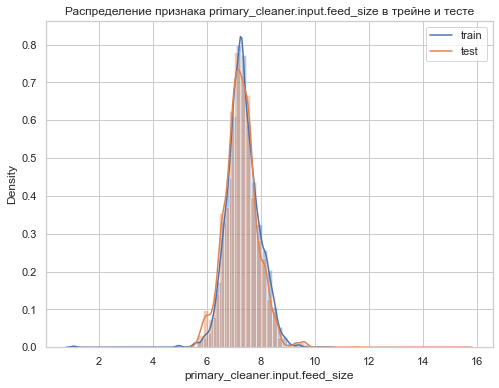

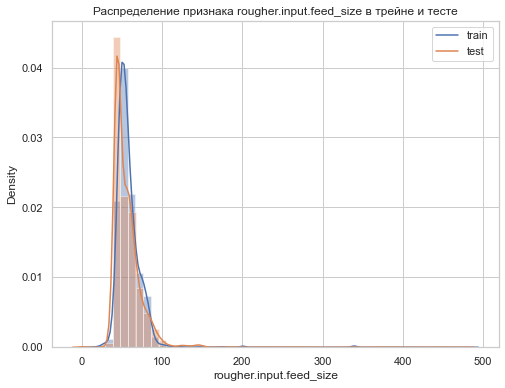

In [33]:
#посмотрим как распределены признаки в выборках
for feat in feed_size_features:
    sns.distplot(df_train_cl[feat])
    sns.distplot(df_test_cl[feat])
    plt.title(f'Распределение признака {feat} в трейне и тесте')
    plt.legend(['train', 'test'])
    plt.show()

Признаки в выборках распределены похожим образом. По таблицам статистик также больших раличий не видно.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [34]:
#посмотрим какие признаки связаны с концентрацией
[i for i in df_full_cl.columns if 'concentrate' in i]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au']

Концентрацию метталов на этапах флотации, очистки и финального концентрата просуммируем и посмотрим распределения. Это позволит выявить аномальные значения.

In [35]:
def concentrate_filter(df, filter):
    #функция фильтр возвращает суммарную концентрацию металла
    concentrate_sum = df.filter(like=filter).sum(axis=1)
    return concentrate_sum

def distplot_for_concentrate(df, filter):
    #функция для построения распределения суммы концентрации металлов на выбранном этапе
    concentrate_sum = concentrate_filter(df, filter)
    sns.distplot(concentrate_sum).set(title=f'Распределение суммы признаков {filter}')

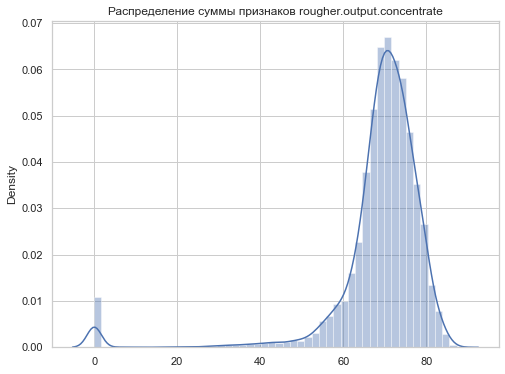

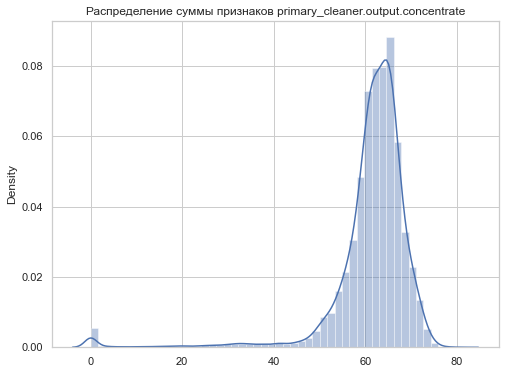

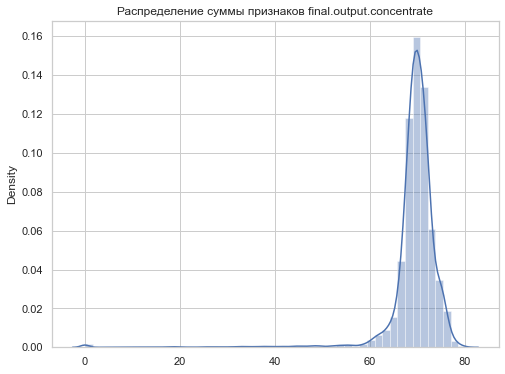

In [36]:
concentrate_stage = ['rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']

for name in concentrate_stage:
    distplot_for_concentrate(df_full_cl, name)
    plt.show()

Есть аномалии в виде нулевых значений. Суммарная нулевая концентрация всех металлов выглядит подозрительно. Отфильтруем аномальные значения в обучающей и тестовой выборках.

In [37]:
def null_filter(df): 
    #функция для очистки датафремаа от нулевых значений
    for stage in concentrate_stage:
        outliers = (concentrate_filter(df_full_cl, stage) == 0)
        idx = set(df_full_cl[outliers].index).intersection(set(df.index))
        df = df.drop(idx)
    return df

In [38]:
#размер выборок до фильтрации
df_train_cl.shape, df_test_cl.shape

((12679, 54), (5383, 52))

In [39]:
#отфильтруем нули в датафреймах
df_train_cl = null_filter(df_train_cl)
df_test_cl = null_filter(df_test_cl)

#размер выборок после фильтрации
df_train_cl.shape, df_test_cl.shape

((12399, 54), (5248, 52))

### Вывод

- посмотрели как меняется распределение сырья на разных этапах, золото увеличивается с каждым этапом, что говорит об эффективности обогащения;
- посмотрели распределения гранул сырья в обучающей и тестовой выборках, сильных отличий не обнаружено, можем быть уверены в правильной оценке модели;
- посмотрели как изменяется суммарная концентрация металлов на разных этапах очистки, обнаружили аномалии и отфильтровали датасеты от выбросов.

# 3. Модель

#### Метрика качества модели

Для оценки модели выбранны метрики sMAPE. Напишем функцию для расчета данной метрики.



$$ sMAPE = \displaystyle\frac{1}{N}\sum_{i=1}^{N}\frac{\left |y_i - \hat{y_i}\right|}{(\left |y_i\right| + \left |\hat{y_i}\right|)/2} \times 100\%$$

In [40]:
def smape(y, a):
    '''Функция для расчета метрики sMAPE.
    Принимает вектор правильных ответов и вектор ответов модели.
    Возвращает значение метрики в процентах'''
    smape = 1/len(y) * sum(2*abs(y - a) / ( abs(y) + abs(a) )) * 100
    return smape

#проверим работу функции на искусственных векторах
vec_y = pd.Series([10, 11, 12, 14, 15])
vec_a = pd.Series([10, 11, 12, 14, 15])
vec_aa = pd.Series([9, 11, 12, 14, 80])

smape(vec_y, vec_a), smape(vec_y, vec_aa)

(0.0, 29.47368421052632)

In [41]:
def smape_total(rougher_smape, final_smape):
    '''Функция для расчета итоговой метрики sMAPE. 
    Принимает метрики sMAPE этапов: флотация и итоовый концентрат.
    Возвращает итоговый sMAPE.'''
    return 0.25 * rougher_smape + 0.75 * final_smape

Фунции для расчета значений метрик сделали. Преходим к разделению признаков на трейн и таргет.

In [42]:
#разделим признаки обучающей выборки на трейн и таргет
features_train = df_train_cl.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_r = df_train_cl['rougher.output.recovery']
target_train_f = df_train_cl['final.output.recovery']

#в тестовую выборку добавим таргеты из полного датасета, чтобы мы могли посчитать метрику качества модели
df_test_cl = df_test_cl.join(df_full_cl[['rougher.output.recovery', 'final.output.recovery']])
df_test_cl = df_test_cl.dropna()

#разделим признаки тестовой выборки на трейн и таргет
features_test = df_test_cl.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_r = df_test_cl['rougher.output.recovery']
target_test_f = df_test_cl['final.output.recovery']

#посмотрим размеры выборок
display(features_train.shape, target_train_r.shape, target_train_f.shape)
display(features_test.shape, target_test_r.shape, target_test_f.shape)

(12399, 52)

(12399,)

(12399,)

(4942, 52)

(4942,)

(4942,)

### Линейная регрессия

Наша задача - предсказание непревной переменной, поэтому начнем с модели линейной регрессии. Обучим модель на кросс-валидации. Оценим качество по выбранной метрике.

In [43]:
#сделаем метрику для кросс-валидации
smape_loss = make_scorer(smape, greater_is_better=False)

def smape_on_cv(model, features, target, cv=5):
    #фукция принимает модель, признаки, таргет и возвращает значение метрики sMAPE на кросс-валидации
    return abs(cross_val_score(model, features, target, cv=cv, scoring=smape_loss).mean())

#создаем объект линейной регрессии
lr_model = LinearRegression()

#словарь для сохраниения значений метрик
metrics_dict = {'model':['linear regression'],
                'smape_rougher':[],
                'smape_final':[],
                'smape_res':[]   
}

#обучим модель на кросс-валидации и посмотрим значение 
smape_rougher = smape_on_cv(lr_model, features_train, target_train_r)
                                               

smape_final = smape_on_cv(lr_model, features_train, target_train_f)

smape_res = smape_total(smape_rougher, smape_final)


def print_metrics():
    #функция для вывода метрик модели
    print('Среднее значение метрики sMAPE (флотация): {:.2f}'.format(smape_rougher))
    print('Среднее значение метрики sMAPE (итоговый концентрат): {:.2f}'.format(smape_final))
    print('Итоговое sMAPE: {:.2f}'.format(smape_res))

print_metrics()

Среднее значение метрики sMAPE (флотация): 7.17
Среднее значение метрики sMAPE (итоговый концентрат): 10.35
Итоговое sMAPE: 9.55


In [44]:
#положим значения в словарь
metrics_dict['smape_rougher'].append(smape_rougher)
metrics_dict['smape_final'].append(smape_final)
metrics_dict['smape_res'].append(smape_res)

Относительно небольшая ошибка для модели линейной регрессии. Далее обучим и проверим модель решающего дерева.

### Решающее дерево

In [45]:
#добавим строку с названием модели в словарь
metrics_dict['model'].append('decision tree')

In [46]:
#созданим объект модели решающего дерева
tree_model = DecisionTreeRegressor(random_state=17, max_depth=10)

#посчитаем метрики на кросс валидации
smape_rougher = smape_on_cv(tree_model, features_train, target_train_r)                                            

smape_final = smape_on_cv(tree_model, features_train, target_train_f)

smape_res = smape_total(smape_rougher, smape_final)

#выведем метрики
print_metrics()


Среднее значение метрики sMAPE (флотация): 10.01
Среднее значение метрики sMAPE (итоговый концентрат): 15.58
Итоговое sMAPE: 14.19


In [47]:
#положим значения в словарь
metrics_dict['smape_rougher'].append(smape_rougher)
metrics_dict['smape_final'].append(smape_final)
metrics_dict['smape_res'].append(smape_res)

Ошибка деревьев решений немного выше чем у линейной регрессии. Посмотрим как покажет себя модель случайного леса. 

### Случайный лес

In [48]:
#добавим название модели в словарь
metrics_dict['model'].append('random forest')

In [49]:
#создадим объект модели случайного леса
forest_model = RandomForestRegressor(random_state=17, n_estimators=10)

#посчитаем метрики на кросс валидации
smape_rougher = smape_on_cv(forest_model, features_train, target_train_r)

smape_final = smape_on_cv(forest_model, features_train, target_train_f)

smape_res = smape_total(smape_rougher, smape_final)

#выведем метрики
print_metrics()


Среднее значение метрики sMAPE (флотация): 6.80
Среднее значение метрики sMAPE (итоговый концентрат): 10.17
Итоговое sMAPE: 9.33


In [50]:
#положим значения в словарь
metrics_dict['smape_rougher'].append(smape_rougher)
metrics_dict['smape_final'].append(smape_final)
metrics_dict['smape_res'].append(smape_res)

In [51]:
#выведем таблицу метрик
results = pd.DataFrame(metrics_dict)
results.style.set_caption('Метрики различных моделей')

,model,smape_rougher,smape_final,smape_res
0,linear regression,7.167265,10.347400,9.552366
1,decision tree,10.013847,15.575449,14.185049
2,random forest,6.802414,10.171946,9.329563


В базовом варианте случайный лес выдает наименьшую ошибку. Продолжим работу с этой моделью. В следующих этапах: 
1. посмотрим важность признаков;
2. проверим как заполненые пропуски отражаются на качестве модели;
3. оптимизируем гипперпараметры, улучшим качество модели.

### Исследование важности признаков

In [52]:
forest_model_r = RandomForestRegressor(random_state=17)
forest_model_r.fit(features_train, target_train_r)

forest_model_f = RandomForestRegressor(random_state=17)
forest_model_f.fit(features_train, target_train_f)

RandomForestRegressor(random_state=17)

In [53]:
def fnames_selection(model, features_train):
    #функция принимает модель, признаки и возвращает список отобранных признаков у которых коэффициент важности Джини больше 1%
    feats = {}
    for feature, importance in zip(features_train.columns, model.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    sns.set(font_scale = 5)
    sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
    fig, ax = plt.subplots()
    fig.set_size_inches(30,15)
    sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
    plt.xlabel('Importance', fontsize=25, weight = 'bold')
    plt.ylabel('Features', fontsize=25, weight = 'bold')
    plt.title('Feature Importance', fontsize=25, weight = 'bold')
    display(plt.show())
    display(importances.style.set_caption('Значения важности признаков'))
    
    return [x for x in importances[importances['Gini-Importance'] > 0.01]['Features']]

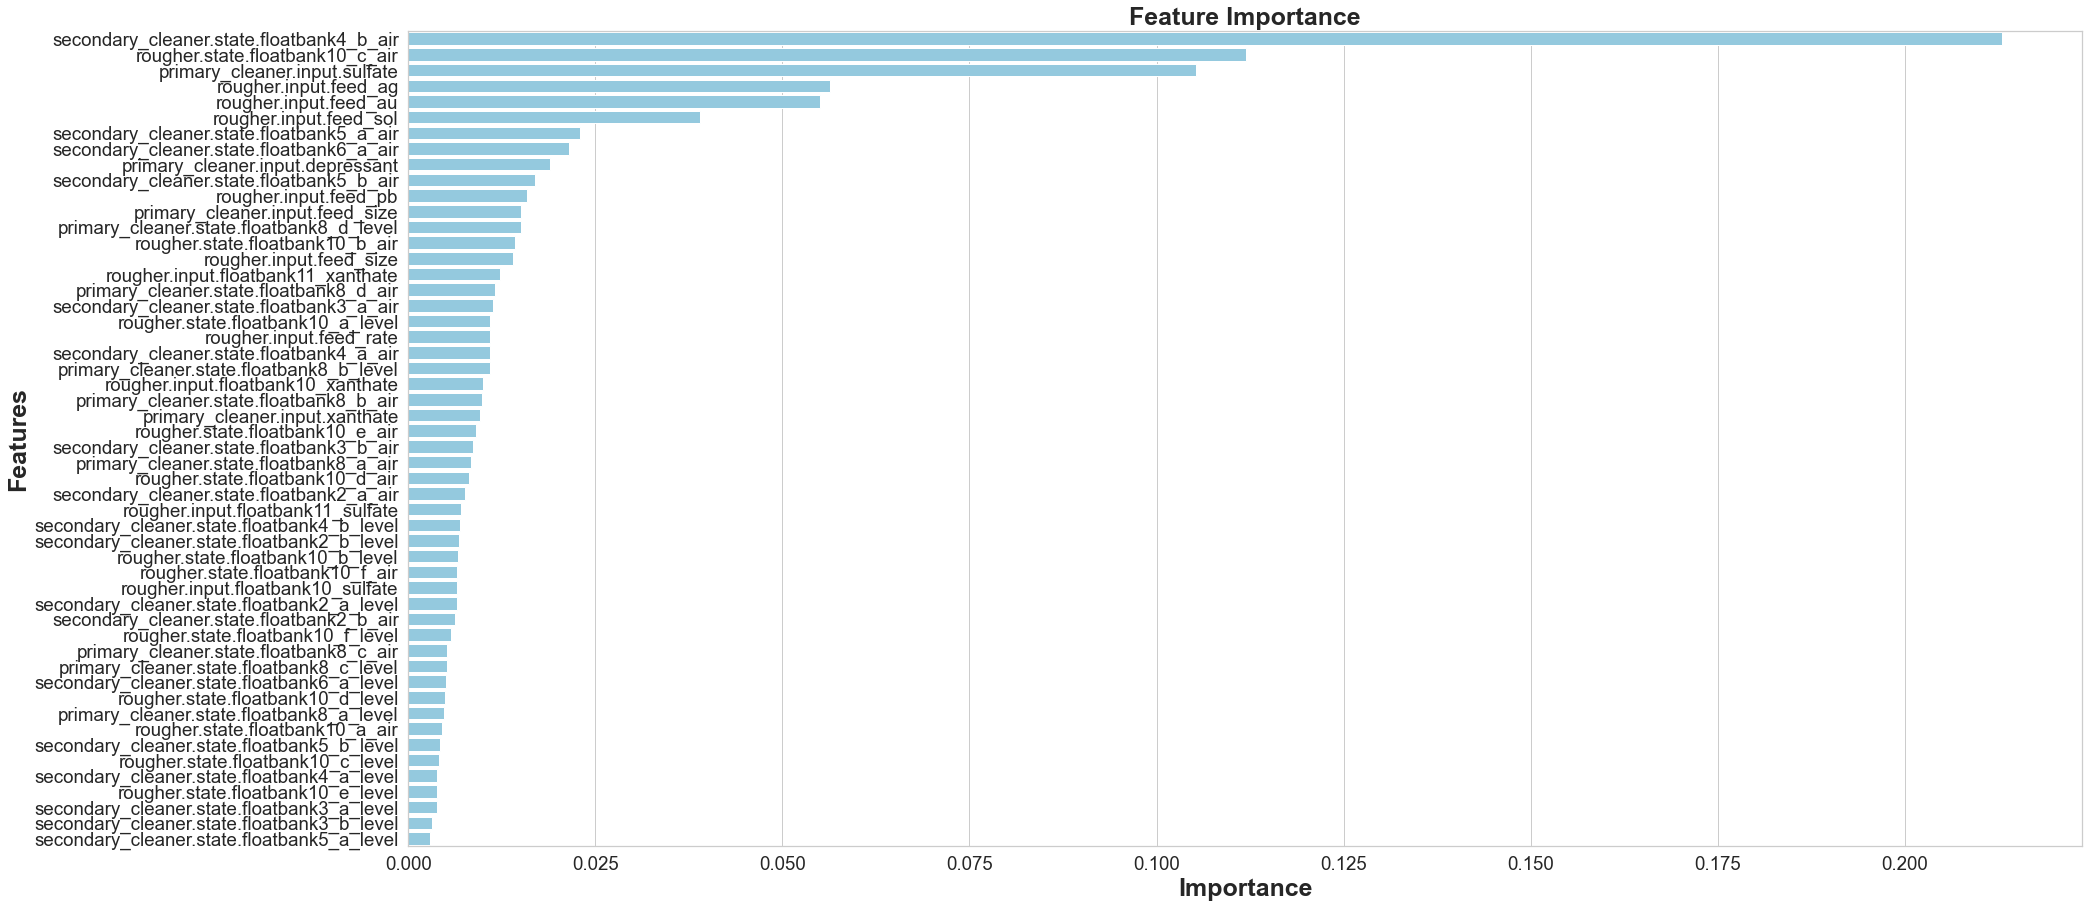

None

,Features,Gini-Importance
0,secondary_cleaner.state.floatbank4_b_air,0.213033
1,rougher.state.floatbank10_c_air,0.111964
2,primary_cleaner.input.sulfate,0.105284
3,rougher.input.feed_ag,0.056318
4,rougher.input.feed_au,0.055035
5,rougher.input.feed_sol,0.039050
6,secondary_cleaner.state.floatbank5_a_air,0.022956
7,secondary_cleaner.state.floatbank6_a_air,0.021482
8,primary_cleaner.input.depressant,0.018972
9,secondary_cleaner.state.floatbank5_b_air,0.016925


Отобрано признаков: 22


In [54]:
#отберем признаки для флотации
fnames_new_r = fnames_selection(forest_model_r, features_train)
print('Отобрано признаков:', len(fnames_new_r))

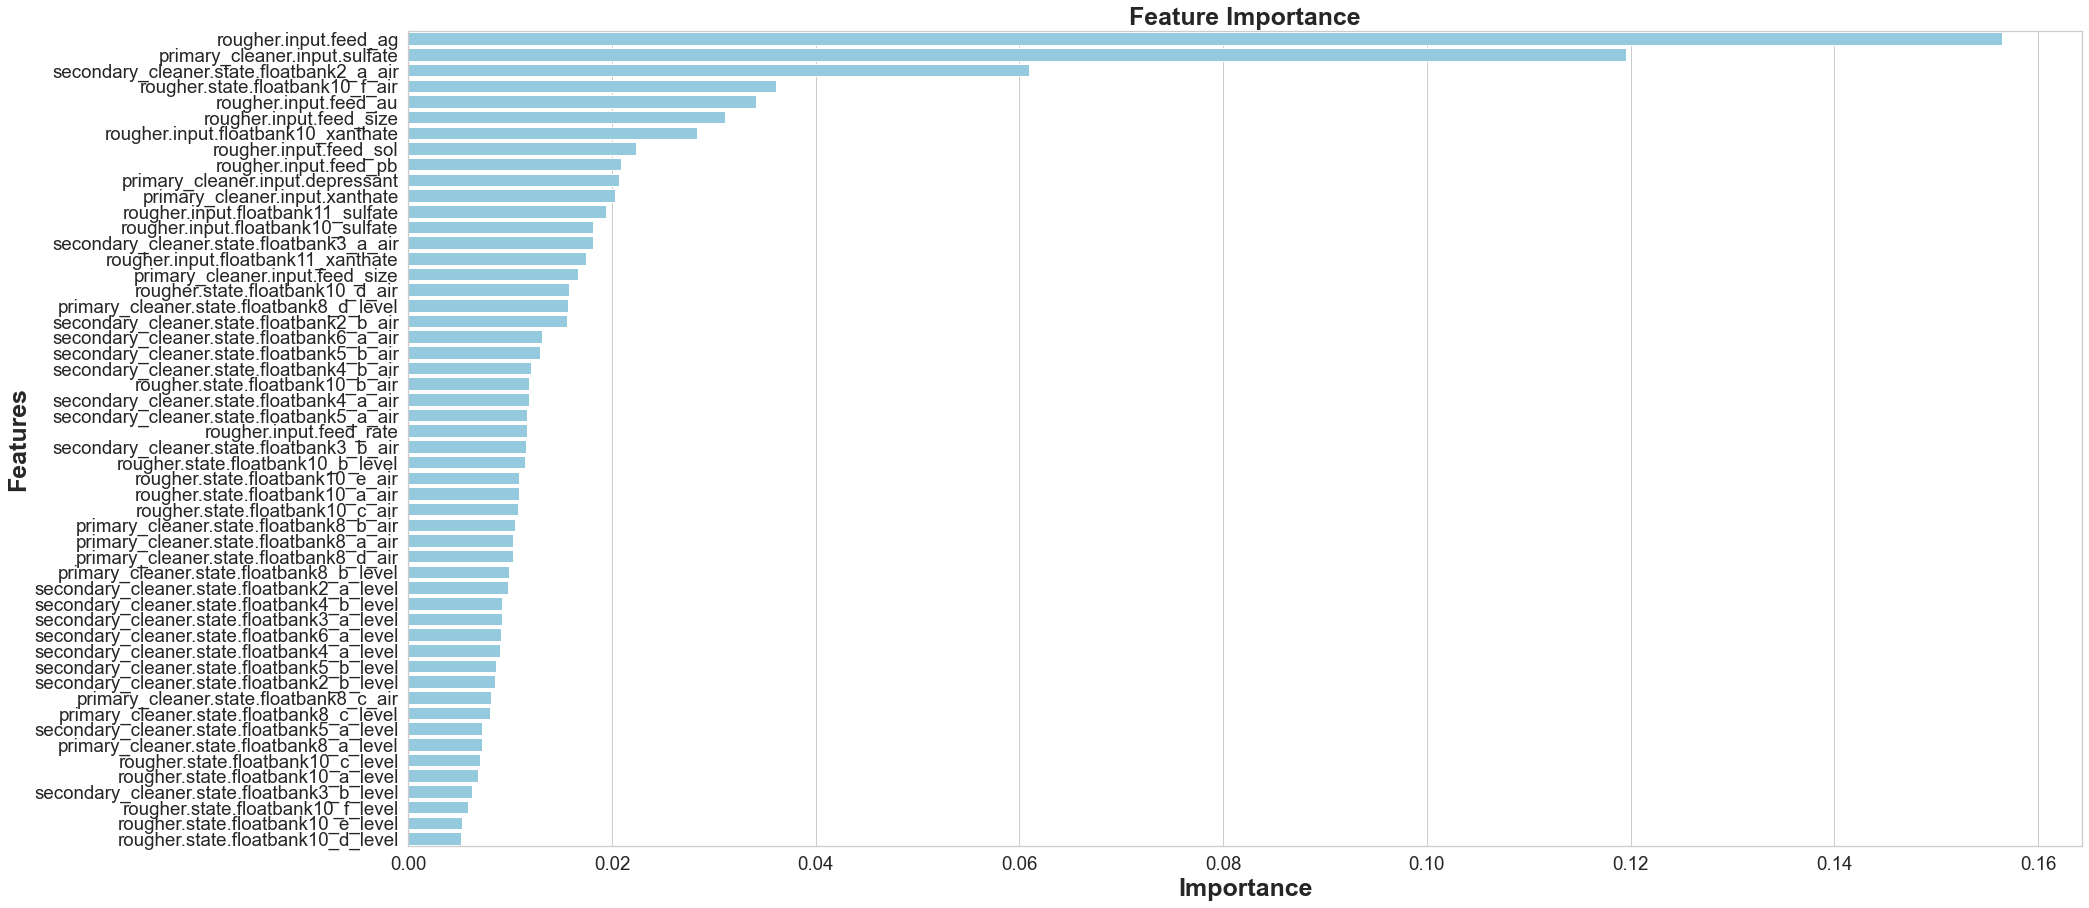

None

,Features,Gini-Importance
0,rougher.input.feed_ag,0.156501
1,primary_cleaner.input.sulfate,0.119563
2,secondary_cleaner.state.floatbank2_a_air,0.060897
3,rougher.state.floatbank10_f_air,0.036126
4,rougher.input.feed_au,0.034143
5,rougher.input.feed_size,0.031128
6,rougher.input.floatbank10_xanthate,0.028317
7,rougher.input.feed_sol,0.022384
8,rougher.input.feed_pb,0.020929
9,primary_cleaner.input.depressant,0.020725


Отобрано признаков: 34


In [55]:
#отберем признаки для финального концетрата
fnames_new_f = fnames_selection(forest_model_f, features_train)
print('Отобрано признаков:', len(fnames_new_f))

In [56]:
forest_model_r = RandomForestRegressor(random_state=17, n_estimators=10)
forest_model_f = RandomForestRegressor(random_state=17, n_estimators=10)


#посчитаем метрики на кросс-валидации
smape_rougher = smape_on_cv(forest_model_r, features_train[fnames_new_r], target_train_r) 
                                        
smape_final = smape_on_cv(forest_model_f, features_train[fnames_new_f], target_train_f) 

smape_res = smape_total(smape_rougher, smape_final)

#выведем метрики
print_metrics()

Среднее значение метрики sMAPE (флотация): 6.12
Среднее значение метрики sMAPE (итоговый концентрат): 9.88
Итоговое sMAPE: 8.94


После отбора признаков ошибка стала немного меньше.

#### Тестирование модели на признаках с заполнеными пропусками

1. Строки с пропущенными значниями в целевой переменной удалим, чтобы обучать модель на реальных ответах.
2. Для заполнения пропусков в признаках воспользуемся методом *forward fill*, он хорошо подходит для временных рядов.

In [57]:
#посмотрим размер тренировочной выборки
df_train.shape

(16860, 54)

In [58]:
#удалим строки в которых целевые переменные пропущенны 
df_train_fl = df_train.drop(df_train[df_train['final.output.recovery'].isna()].index) 
df_train_fl = df_train.drop(df_train[df_train['rougher.output.recovery'].isna()].index) 

#заполним пропуски в выборке
df_train_fl = df_train_fl.fillna(method='ffill')
df_train_fl.shape

(14287, 54)

In [59]:
#разделим признаки обучающей выборки на трейн и таргет
features_train_fl = df_train_fl.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_r_fl = df_train_fl['rougher.output.recovery']
target_train_f_fl = df_train_fl['final.output.recovery']

#посмотрим размеры выборок
display(features_train.shape, target_train_r.shape, target_train_f.shape)

(12399, 52)

(12399,)

(12399,)

In [60]:
forest_model_r = RandomForestRegressor(random_state=17, n_estimators=10)
forest_model_f = RandomForestRegressor(random_state=17, n_estimators=10)


#посчитаем метрики на кросс-валидации
smape_rougher = smape_on_cv(forest_model_r, features_train_fl, target_train_r_fl) 
                                        
smape_final = smape_on_cv(forest_model_f, features_train_fl, target_train_f_fl) 

smape_res = smape_total(smape_rougher, smape_final)

#выведем метрики
print_metrics()

Среднее значение метрики sMAPE (флотация): 14.63
Среднее значение метрики sMAPE (итоговый концентрат): 12.68
Итоговое sMAPE: 13.17


In [61]:
#выведем результаты ранее обученых моделей
results

,model,smape_rougher,smape_final,smape_res
0,linear regression,7.167265,10.347400,9.552366
1,decision tree,10.013847,15.575449,14.185049
2,random forest,6.802414,10.171946,9.329563


После заполнения пропусков качество модели упало. Вернемся к признакам, очищенным от пропусков.

#### Оптимизация гипперпараметров

Гипперпарамеры подберем методом RandomazedSearchCV

In [62]:
def randomized_search_cv(model, features_train, target_train):
    #функция для случайного поиска гипперпараметров
    #возвращает объект с параметрами
    n_estimators = [120, 300, 500, 800, 1200]
    max_features = ['log2', 'sqrt']
    max_depth = [5, 8, 15, 25, 30]
    min_samples_split = [2, 5, 10, 15]
    min_samples_leaf = [2, 5, 10]
    bootstrap = [True, False]

    params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

    rs = RandomizedSearchCV(model, 
                        params, 
                        cv = 3, 
                        verbose = 1,
                        n_jobs=-1,
                        scoring=smape_loss,
                        random_state=17)


    rs.fit(features_train, target_train)
    
    return rs

In [63]:
%%time
#выделим отобраные признаки
features_train_r = features_train[fnames_new_r]
features_train_f = features_train[fnames_new_f]

#запустим случайный поиск для флотации
rs_r = randomized_search_cv(forest_model_r, features_train_r, target_train_r)

#запустим случайный поиск для финального концентрата
rs_f = randomized_search_cv(forest_model_f, features_train_f, target_train_f)

#получим лучую метрику на кросс-валидации
smape_rougher = abs(rs_r.best_score_)
smape_final = abs(rs_f.best_score_)

smape_res = smape_total(smape_rougher, smape_final)

print_metrics()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.3min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.2min finished


Среднее значение метрики sMAPE (флотация): 6.96
Среднее значение метрики sMAPE (итоговый концентрат): 9.53
Итоговое sMAPE: 8.89
Wall time: 6min 2s


In [64]:
#положим значения в словарь
metrics_dict['model'].append('forest random search cv')
metrics_dict['smape_rougher'].append(smape_rougher)
metrics_dict['smape_final'].append(smape_final)
metrics_dict['smape_res'].append(smape_res)

In [65]:
pd.DataFrame(metrics_dict)

,model,smape_rougher,smape_final,smape_res
0,linear regression,7.167265,10.347400,9.552366
1,decision tree,10.013847,15.575449,14.185049
2,random forest,6.802414,10.171946,9.329563
3,forest random search cv,6.962048,9.529664,8.887760


Гипперпараметры подобрали. На кросс-валидации оценка модели с новыми гипперпараметрами стала лучше. Далее обучим модет на полной тестовой выборке и сравним с тестовой выборкой.

# 4. Тестирование модели

In [66]:
#отберем признаки для тренировочной выборки
features_train_r = features_train[fnames_new_r]
features_train_f = features_train[fnames_new_f]

#отберем признаки для тестовой выборки
features_test_r = features_test[fnames_new_r]
features_test_f = features_test[fnames_new_f]

In [67]:
#отберем лучшую модель для флотации
forest_rs_r = rs_r.best_estimator_
#обучим на полной тренировочной выборке и сделаем предсказание
forest_rs_r.fit(features_train_r, target_train_r)
predictions_r = forest_rs_r.predict(features_test_r)

#отмерем лучшую модель для финального концентрата
forest_rs_f = rs_f.best_estimator_
#обучим на полной тренировочной выборке и сделаем предсказание
forest_rs_f.fit(features_train_f, target_train_f)
predictions_f = forest_rs_f.predict(features_test_f)

#посчитаем метрики моделей
smape_rougher = smape(target_test_r, predictions_r)

smape_final = smape(target_test_f, predictions_f)

smape_res = smape_total(smape_rougher, smape_final)

print_metrics()

Среднее значение метрики sMAPE (флотация): 4.00
Среднее значение метрики sMAPE (итоговый концентрат): 7.14
Итоговое sMAPE: 6.35


In [68]:
#положим значения в словарь
metrics_dict['model'].append('best model')
metrics_dict['smape_rougher'].append(smape_rougher)
metrics_dict['smape_final'].append(smape_final)
metrics_dict['smape_res'].append(smape_res)

#### Сравнение с константной моделью

In [69]:
metrics_dict['model'].append('constant model')

#сделаем константное предсказание медианой
const_pred_r = pd.Series(target_train_r.median(), index=target_test_r.index)
const_pred_f = pd.Series(target_train_f.median(), index=target_test_f.index)

#сравним метрики с тестовой выборкой
smape_rougher = smape(target_test_r, const_pred_r)

smape_final = smape(target_test_f, const_pred_f)

smape_res = smape_total(smape_rougher, smape_final)

print_metrics()

Среднее значение метрики sMAPE (флотация): 4.65
Среднее значение метрики sMAPE (итоговый концентрат): 7.86
Итоговое sMAPE: 7.06


In [70]:
#положим значения в словарь
metrics_dict['smape_rougher'].append(smape_rougher)
metrics_dict['smape_final'].append(smape_final)
metrics_dict['smape_res'].append(smape_res)

In [71]:
results = pd.DataFrame(metrics_dict)
results.style.set_caption('Метрики различных моделей')

,model,smape_rougher,smape_final,smape_res
0,linear regression,7.167265,10.347400,9.552366
1,decision tree,10.013847,15.575449,14.185049
2,random forest,6.802414,10.171946,9.329563
3,forest random search cv,6.962048,9.529664,8.887760
4,best model,3.995339,7.140372,6.354114
5,constant model,4.647085,7.862312,7.058506


Лучшая модель слуйного леса прошла проверку на адекватность: оценка лучше чем у константной модели.

# 5. Вывод

- Построили три различных модели. Наилучшая оценка у модели случайного леса. 
- Провели отбор признаков. Тем самым уменьшили размерность выборки, упростили вычисления и улучшили оценку качества. Количество признаков модели предсказания эффективности обогащения чернового концентрата сократили до 21, для модели финального концентрата до 34.
- Проверили оценку модели после заполнения пропусков в признаках. Оценка модели стала хуже, поэтому вернулись к признакам с очищенными пропусками.
- Оптимизировали гипперпараметры моделей методом случайного поиска на кросс-валидации. Улучшили оценку. Выбрали лучшие модели.
- Обучили лучшие модели на полной тренировочной выборке. Получили оценку метрик на тестовой выборке и сравнили модели с константной моделью. Выбранные модели показывают лучшие значение метрик sMAPE.
